**Drake Meets World: Sowmya Murali**
======
***

### * <font color='#A5A5A5'>Exploring Drake's growth through analysis of his lyrics</font> *

***
<font color='#595959'>
### Table of Contents
#### Part 1: Scrape Lyrics
#### Part 2: Create Metrics
    1 Sentiment Score
    2 Lexical Complexity
#### Part 3: Create Visualizations for Metrics
    1 Sentiment Score for Songs
    2 Lexical Complexity for Songs
    3 Sentiment Score & Lexical Complexity by Year
    4 Sentiment Score by Lexical Complexity
#### Part 4: Topic Analysis of Lyrics
#### Part 5: Word Cloud of Lyrics
#### Part 6: Next Steps
</font>
***

### Import Modules

In [91]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import re
import string
import nltk
from unidecode import unidecode
import textblob
from textblob import Word,TextBlob
from collections import Counter
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Part 1: Scrape Lyrics
***

### Read csv with song names

#### * <font color='gray'>I created a list of songs and albums I wanted to analyze (copied from metrolyrics)</font> *

In [4]:
quote_page = 'http://metrolyrics.com/{}-lyrics-drake.html'
filename = '/Users/sowmyamurali/Documents/DataViz/drakedata.csv'
songs = pd.read_csv(filename,encoding = "latin1")
songs = songs.replace("'", '',regex=True)
songs = songs.replace("&", '',regex=True)
songs = songs.replace("/", '',regex=True)

songs.album = songs.album.str.strip()
songs.song = songs.song.str.strip()

songs = songs.replace(' ', '-',regex=True)

### Scrape lyrics from Metrolyrics

In [ ]:
#scrape metrolyrics for the lyrics
for index, row in songs.iterrows():
    page = urllib2.urlopen(quote_page.format(row['song']))
    soup = BeautifulSoup(page, 'html.parser')
    verses = soup.find_all('p', attrs={'class': 'verse'})

    lyrics = ''

    for verse in verses:
        text = verse.text.strip()
        text = re.sub(r"\[.*\]\n", "", unidecode(text))
        if lyrics == '':
            lyrics = lyrics + text.replace('\n', ' ')
        else:
            lyrics = lyrics + ' ' + text.replace('\n', ' ')

    songs.at[index, 'lyrics'] = lyrics

### Replace blanks with NAs, delete blank lyrics and clean up formating

In [78]:
songs = songs.replace('',np.nan, regex=True)
songs = songs.replace(',','', regex=True)
songs = songs.dropna(subset=['lyrics'], thresh=1)

In [41]:
songs['album'] = songs['album'].astype(str)
songs['album'] = songs['album'].str.lower()

songs = songs.replace('-', ' ',regex=True)

### Save scraped lyrics to csv

In [82]:
songs.to_csv('/Users/sowmyamurali/Documents/DataViz/drakedata_NEW.csv',index=False)
songs = pd.read_csv('/Users/sowmyamurali/Documents/DataViz/drakedata_NEW.csv')

In [185]:
df_songMetrics = songs.copy()

## Part 2: Create Metrics
***

### Create sentiment score for lyrics

In [186]:
#sentiment score
df_songMetrics[['polarity', 'subjectivity']] = df_songMetrics['lyrics'].apply(lambda x: pd.Series(TextBlob(x).sentiment))
df_songMetrics['sentiment'] = df_songMetrics['lyrics'].apply(lambda x: TextBlob(x).sentiment[0] )

### Calculate lexical complexity for lyrics

#### * <font color='gray'>I defined lexical complexity by the number of unique words out of total words</font> *

In [187]:
#complexity of songs
df_songMetrics['lyrics'] = df_songMetrics['lyrics'].astype(str)
df_songMetrics['lyrics'] = df_songMetrics['lyrics'].str.lower()

#total count of words
df_songMetrics['word_counts'] = np.nan
df_songMetrics.loc[[not row for row in np.isnan(df_songMetrics.sentiment)],'word_counts'] =\
df_songMetrics.loc[[not row for row in np.isnan(df_songMetrics.sentiment)],'lyrics'].apply(lambda x : len(x.split()))

#unique count of words
df_songMetrics['unique_word_counts'] = np.nan
df_songMetrics.loc[[not row for row in np.isnan(df_songMetrics.sentiment)],'unique_word_counts'] =\
df_songMetrics.loc[[not row for row in np.isnan(df_songMetrics.sentiment)],'lyrics'].apply(lambda x : len(set(x.split())))

#lexical complexity
df_songMetrics['lexical_complexity'] = df_songMetrics['unique_word_counts']/df_songMetrics['word_counts']

## Part 3: Create Visualizations for Metrics
***

### Plot Sentiment Scores for Songs

In [235]:
trace1 = go.Scatter(
    x = df_songMetrics['song'],
    y = df_songMetrics['sentiment'],
    mode='markers',
    marker=dict(
        size=16,
        color = df_songMetrics['sentiment'], #set color equal to a variable
        colorscale='Portland',
        showscale=True
    )
)
data = [trace1]
layout = go.Layout(
        title = 'Sentiment Score for Songs',
        titlefont = dict(size=22),
         xaxis = dict(
            title = 'Song',
            titlefont = dict(size=16),
            showticklabels=False),
         yaxis = dict(
            title = 'Sentiment Score',
            titlefont = dict(size=16),
            autorange = True,
            showgrid = True,
            zeroline = True,
            dtick = 1,
            gridcolor = '#BBC7A4',
            gridwidth = 1,
            zerolinecolor = '#BBC7A4',
            zerolinewidth = 3),
        margin = dict(
            l = 40,
            r = 30,
            b = 170,
            t = 100),
        showlegend=False)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-plot-with-colorscale')

#### Insights
+ Not surprising a majority of Drake's songs are relatively neutral or positive
+ One song I was surprised by was "Know Yourself" which got a sentiment score of -0.16 but when I went back and read the lyrics I realized "woe" was the most used word and could have contributed to the lower sentiment score
+ Currently a very popular song, "Nice for What" got a sentiment score of 0.03 although the lyrics aren't overly positive, it does have an overall positive message which explains the somewhat neutral sentiment score

### Plot Lexical Complexity for Songs

In [236]:
trace1 = go.Scatter(
    x= df_songMetrics['song'],
    y= df_songMetrics['lexical_complexity'],
    mode='markers',
    marker=dict(
        size=16,
        color = df_songMetrics['lexical_complexity'], #set color equal to a variable
        colorscale='Portland'
    ),
    text= df_songMetrics['song'])
data = [trace1]

layout = go.Layout(
        title = 'Lexical Complexity for Songs',
        hovermode= 'closest',
        titlefont = dict(size=22),
         xaxis = dict(
            title = 'Song',
            titlefont = dict(size=16),
            showticklabels=False),
         yaxis = dict(
            title = 'Lexical Complexity',
            titlefont = dict(size=16),
            autorange = True,
            showgrid = True,
            zeroline = True,
            dtick = 0.1,
            gridcolor = '#BBC7A4',
            gridwidth = 1,
            zerolinecolor = '#BBC7A4',
            zerolinewidth = 3),
        margin = dict(
            l = 100,
            r = 30,
            b = 180,
            t = 100),
        showlegend=False)

fig = dict(data=data,layout=layout)
iplot(fig, filename='complexity')

#### Insights
+ The majority of Drake's songs are around 0.5 or under for lexical complexity. Considering the hook is repeated 3-4 times in each song, the overall low level of complexity is understandable
+ The song with the highest lexical complexity is "Intro" from Comeback Season; however, this intro is only 3 lines so it doesn't really have the same count of words as the other songs which is an average of 503 words
+ My favorite songs seem to be in the 0.3-0.4 complexity range not far from the average lexical complexity for his songs at 0.40

### Average by Year

In [229]:
df_avg = df_songMetrics.groupby(['year']).mean().round(2)
df_avg['year'] = df_avg.index
df_avg = df_avg.replace('â','', regex=True)
df_avg = df_avg.sort_values(by='sentiment',ascending=False)

### Plot Sentiment Scores and Lexical Complexity by Year

In [221]:
trace0 = go.Scatter(
    x = df_avg['year'],
    y = df_avg['sentiment'],
    name = 'Sentiment',
    line = dict(
        color = ('#DA5552'),
        width = 4)
)
trace1 = go.Scatter(
    x = df_avg['year'],
    y = df_avg['lexical_complexity'],
    name = 'Lexical Complexity',
    yaxis='y2',
    line = dict(
        color = ('#06D6A0'),
        width = 4)
)
data = [trace0,trace1]
layout = go.Layout(
        title = 'Sentiment Score & Lexical Complexity by Year',
        titlefont = dict(size=22),
        xaxis = dict(
            title = 'Year',
            titlefont = dict(size=16),
            dtick = 1),    
        yaxis = dict(
            title = 'Sentiment Score',
            titlefont = dict(size=16,color='#DA5552'),
            autorange = True,
            showgrid = True,
            zeroline = True,
            gridcolor = '#BBC7A4',
            gridwidth = 1,
            zerolinecolor = '#BBC7A4',
            zerolinewidth = 3),
        yaxis2=dict(
        title='Lexical Complexity',
        titlefont=dict(size=16,
            color='#06D6A0'
        ),
        overlaying='y',
        side='right'
    ),
        margin = dict(
            l = 80,
            r = 100,
            b = 80,
            t = 100),
        showlegend=False)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-plot-with-colorscale')

#### Insights
+ The sentiment and lexical complexity of Drake's songs seem to move in the same direction through out the years
+ 2017-2018 had the highest lexical complexity at an average of 0.43
+ 2015 had the lowest sentiment score and happens to coincide with the year he released a collaborative mixtape with Future, "What A Time to Be Alive" which focused on dealing with personal demons and insecurities

### Plot Sentiment Scores against Lexical Complexity

In [234]:
trace = go.Scatter(
    x = df_songMetrics['sentiment'],
    y = df_songMetrics['lexical_complexity'],
    mode = 'markers',
    marker = dict(
        size = 14,
        color = '#77E8CB',
        line = dict(
            width = 2,
            color = '#06C392'
        )
    ),
    text= df_songMetrics['song']
)

data = [trace]

layout = go.Layout(
        title = 'Sentiment Score by Lexical Complexity',
        hovermode= 'closest',
        titlefont = dict(size=22),
        xaxis = dict(
            title = 'Sentiment Score',
            titlefont = dict(size=16)),    
        yaxis = dict(
            title = 'Lexical Complexity',
            titlefont = dict(size=16),
            autorange = True,
            showgrid = True,
            zeroline = True,
            dtick = 0.2,
            gridcolor = '#BBC7A4',
            gridwidth = 1,
            zerolinecolor = '#BBC7A4',
            zerolinewidth = 3),
        margin = dict(
            l = 80,
            r = 30,
            b = 80,
            t = 100),
        showlegend=False)

fig = dict(data=data,layout=layout)
iplot(fig, filename='basic-scatter')

#### Insights
+ I was hoping to see a relationship between lexical complexity and sentiment but it looks like they cluster around the center
+ The song with the lowest sentiment score, "Mob Ties" was also on the lower end for lexical complexity at 0.33, even less than the average
+ However, the song with the highest sentiment score, "Best I Ever Had" also happened to be on the lower end for lexical complexity at 0.29

## Part 4: Topic Analysis of Lyrics
***

### Save copy of lyrics for topic analysis

In [195]:
df_topics = songs.copy()

### Create list of the lyrics

In [13]:
lyrics=df_topics['lyrics'].tolist()

### Lemmatize & remove punctuation in the lyrics

#### * <font color='gray'>Lemmatization converts the word into its root word</font> *

In [79]:
lemmatization = lambda x: " ".join([Word(word).lemmatize() for word in x.split()])
lyrics = list(map(lemmatization, lyrics))

#remove punctuation
lyrics = [w.replace('[^\w\s]', '') for w in lyrics]

### Create function to display topics

####  *<font color='gray'>Topics are a repeating pattern of co-occurring terms in a corpus</font> *

In [223]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(['ugh','em','ohhh','aha','ll','oho','ck','ve','ooooooh','hooooooo','mothafuckas','mothafucka','woah','aye','skrrt','hey','huh','wa','hoo','ayy','yuh','ay','ain','ya','ooh','yeah','like','just','know','want','need','got','make','wanna','gonna','gotta','gon','don','oh','tryna','told','this','maybe','cause','nigga','niggas','used'])

def display_topics(H, W, feature_names, documents, no_top_words):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

documents = lyrics
no_topics = 10
no_top_words = 10
no_features = 1000
no_top_documents = 2

###  Use tf-idf for the NMF Model

In [224]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=my_stop_words)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

### Run NMF Model

In [225]:
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

### Display the topics

In [226]:
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words)

Topic 0:
shit love man girl way say time feel thing fuck
Topic 1:
going girl right babe emotion open story usual lover choose
Topic 2:
safe promise mercy fall downtown traffic false asleep address birthday
Topic 3:
mind somethin apologize yellin time rise money decide catch guy
Topic 4:
lonely face ring anybody place really rule baby long mix
Topic 5:
care hurt loved lie carry lost won ashamed tell thinking
Topic 6:
good long getting taking time faded granted wait night hate
Topic 7:
light sun caught party target celebrate wait toast winter dumb
Topic 8:
kissed afford shoulder dont weight right closer emotion secret open
Topic 9:
ho stay wrong different thing end lying love missing touch


#### Insights
+ Most of these topics are emotional with words like "love", "hurt" and "lonely" and generally have the word "girl" or another word for girl (i.e. baby)
+ The most positive topic is Topic 7, with "celebrate" and "party"
+ Overall, I think Drake just wants to talk about his feelings and maybe that's why I like him so much

## Part 5: Word Cloud of Lyrics
***

### Word cloud with mask

In [ ]:
text = " ".join(documents)
stopwords = my_stop_words
mask = np.array(Image.open('/Users/sowmyamurali/Documents/DataViz/drake.jpg'))
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               stopwords=stopwords,max_font_size=90, random_state=42)

### Generate word cloud

In [ ]:
wc.generate(text)

### Display and save wordcloud to file

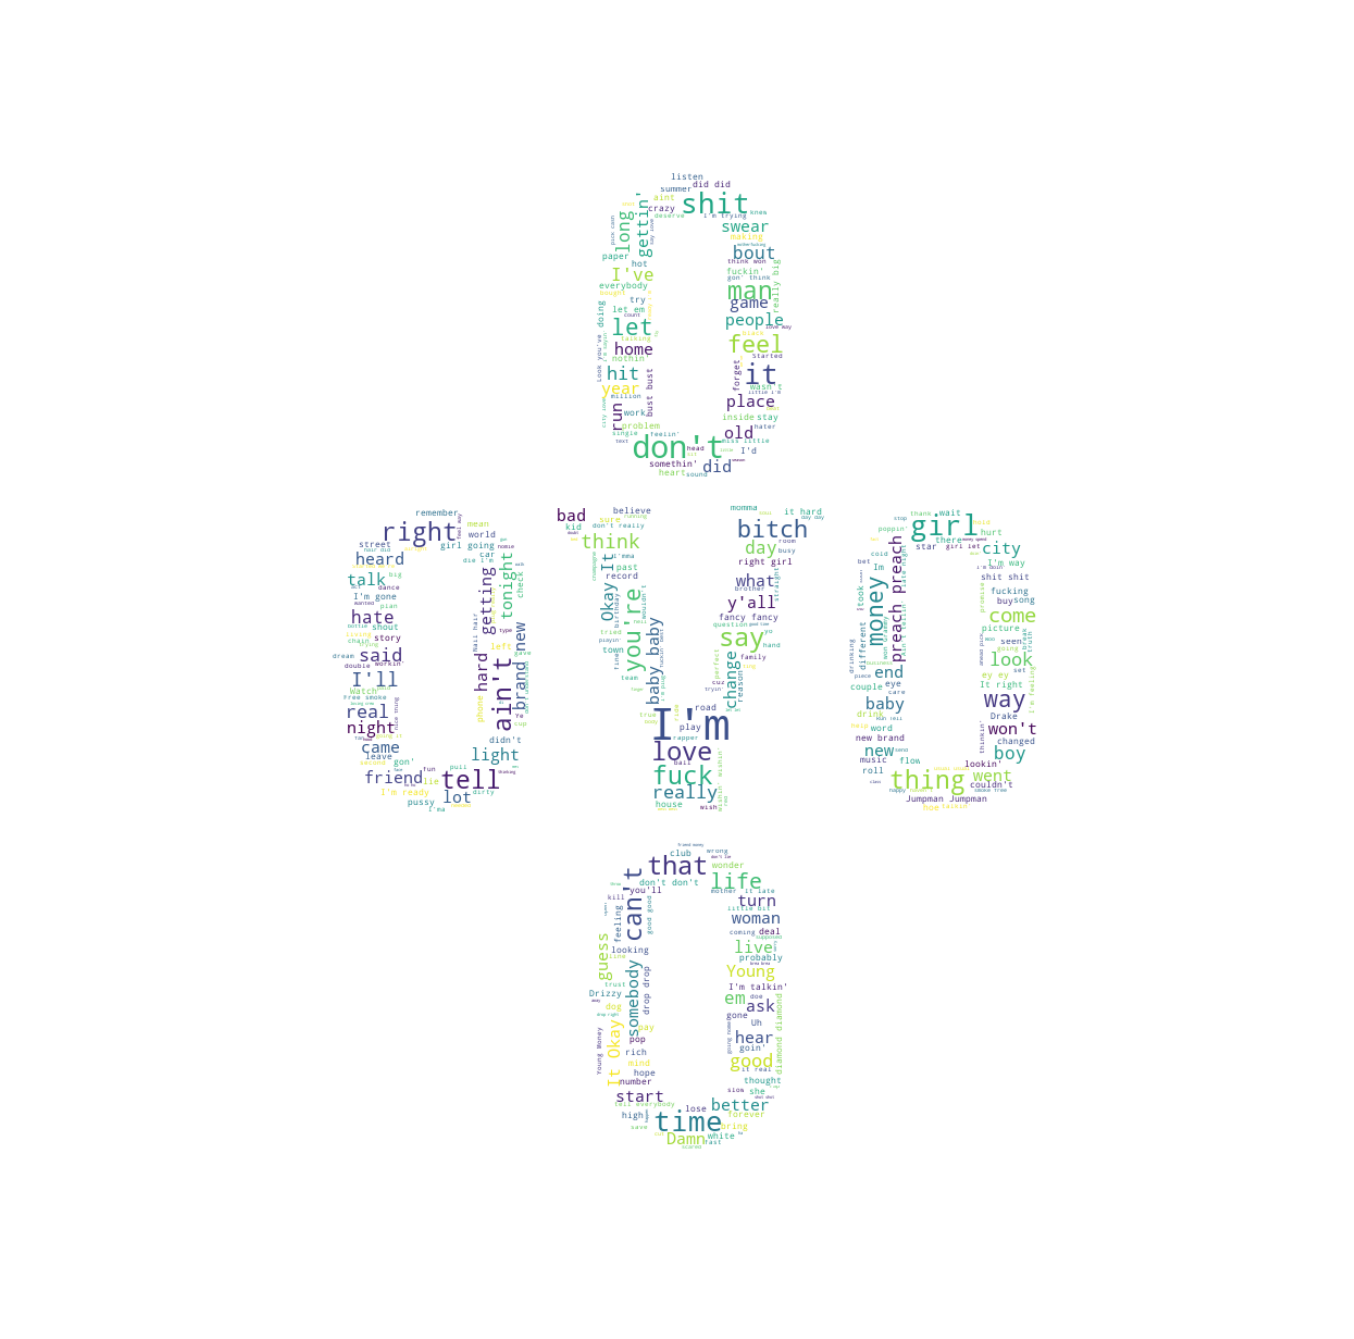

In [76]:
plt.figure(figsize=(24,24))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

wc.to_file('/Users/sowmyamurali/Documents/DataViz/wordcloud.png')

#### Insights
+ Based on the prominent "I'm", I get the sense while I love Drake a lot, Drake loves Drake even more
+ Combined with the topic analysis, the most common these is girls! Whether it's singing about girls or singing to them.

***
<font color='#595959'>
## Part 6: Next Steps
    1 Look at sentiment score & lexical complexity by featured artist and by performance in charts
    2 Topic analysis by album
    3 Visualize cities Drake has sang about (including related sentiment scores for the songs)
    4 Visualize profits for albums/songs by artist featured
</font>
***

In [ ]:
# http://rohankshir.github.io/2016/02/28/topic-modeling-on-hiphop/
# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
# https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
# http://www.mien.in/2017/10/02/visual-text-analytics-with-python/
# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
# https://discuss.analyticsvidhya.com/t/find-number-of-unique-words-in-a-string-text-file-using-python/1788/2
# https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
# https://de.dariah.eu/tatom/topic_model_visualization.html#topic-model-visualization
# https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
# https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d
# https://help.plot.ly/embed-graphs-in-websites/